# Sketchpad for utilising Raster image data

This was an experimental sketchpad to see whether we could use the .tiff data of the province of Utrecht, which houses information about soil etc, as an addition to the existing geopackage data. 

Colleague Anton Ras of the Hogeschool Utrecht build below script for the 'LGN2024.tif' raster data received from the Province of Utrecht. This was not meant for public use, purely for internal experimentation and knowledge gathering, nonetheless it might prove useful for other who'd like to use this particular data type/set.


### Usefull links:
#### understanding bands in the meta data
https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/raster-bands-pro-.htm#:~:text=A%20combination%20of%20any%20three,you%20display%20only%20one%20band.

In [5]:
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np
import os
import xml.etree.ElementTree as ET
import json
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.patches as mpatches


file_path_tiff = './LGN2024/LGN2024.tif' # Path to the raster file
file_path_sld = './LGN2024/LGN2024.sld' # Path to the SLD file

# finding the legends we need to populate the map for later

In [6]:
# Parse the SLD file
tree = ET.parse(file_path_sld)
root = tree.getroot()

legend = {}

# Define the namespace for SLD
namespace = {"sld": "http://www.opengis.net/sld"}

# Extract ColorMapEntry elements
colormap_entries = root.findall(".//sld:ColorMapEntry", namespace)

# Loop through each ColorMapEntry and extract attributes
for entry in colormap_entries:
    quantity = int(entry.attrib["quantity"])  # Pixel value
    color = entry.attrib["color"]  # Hex color
    label = entry.attrib.get("label", f"Category {quantity}")  # Label (default to "Category X" if missing)
    legend[quantity] = {"color": color, "label": label}

# Print the legend in a readable format
print("Legend:")
for quantity, info in legend.items():
    print(f"Pixel Value: {quantity}, Color: {info['color']}, Label: {info['label']}")


with open("legend.json", "w") as json_file:
    json.dump(legend, json_file, indent=4)

# print("\nLegend saved to 'legend.json'")
# print(colormap_entries)

Legend:
Pixel Value: 1, Color: #73df1f, Label: 1 - agrarisch gras
Pixel Value: 2, Color: #e89919, Label: 2 - maïs
Pixel Value: 3, Color: #b26600, Label: 3 - aardappelen
Pixel Value: 4, Color: #e51f7f, Label: 4 - bieten
Pixel Value: 5, Color: #ffff00, Label: 5 - granen
Pixel Value: 6, Color: #ff00c5, Label: 6 - overige landbouwgewassen
Pixel Value: 8, Color: #46ffcf, Label: 8 - glastuinbouw
Pixel Value: 9, Color: #3cef45, Label: 9 - boomgaarden
Pixel Value: 10, Color: #ac81a8, Label: 10 - bloembollen
Pixel Value: 11, Color: #33c800, Label: 11 - loofbos
Pixel Value: 12, Color: #009900, Label: 12 - naaldbos
Pixel Value: 16, Color: #2473ff, Label: 16 - zoet water
Pixel Value: 17, Color: #000099, Label: 17 - zout water
Pixel Value: 18, Color: #ff0000, Label: 18 - bebouwing in primair bebouwd gebied
Pixel Value: 19, Color: #730000, Label: 19 - bebouwing in secundair bebouwd gebied
Pixel Value: 20, Color: #93d600, Label: 20 - bos in primair bebouwd gebied
Pixel Value: 22, Color: #93aa00, Labe

# was interested to see percentage wise how much of each value populated the utrecht area

In [7]:
utrecht_bbox = {
    "left": 130000,  # Minimum X (Easting)
    "bottom": 450000,  # Minimum Y (Northing)
    "right": 140000,  # Maximum X (Easting)
    "top": 460000,  # Maximum Y (Northing)
}


with rasterio.open(file_path_tiff) as src:
    # Calculate the window for the bounding box
    window = src.window(
        utrecht_bbox["left"],
        utrecht_bbox["bottom"],
        utrecht_bbox["right"],
        utrecht_bbox["top"],
    )
    
    utrecht_data = src.read(1, window=window)
    
    # Get the transform for the cropped area
    utrecht_transform = src.window_transform(window)
       
    # Calculate the distribution of categories
    unique, counts = np.unique(utrecht_data, return_counts=True)
    category_areas = dict(zip(unique, counts))

    # Convert pixel counts to percentages
    total_pixels = utrecht_data.size
 
    # Map pixel values to labels and print
    print("\nCategory Distribution with Labels:")
    for category, area in category_areas.items():
        label = legend.get(category, "Unknown")
        percentage = (area / total_pixels) * 100
        print(f"Category {category} ({label}): {percentage:.2f}%")


Category Distribution with Labels:
Category 1 ({'color': '#73df1f', 'label': '1 - agrarisch gras'}): 15.65%
Category 2 ({'color': '#e89919', 'label': '2 - maïs'}): 1.98%
Category 5 ({'color': '#ffff00', 'label': '5 - granen'}): 0.04%
Category 6 ({'color': '#ff00c5', 'label': '6 - overige landbouwgewassen'}): 0.11%
Category 8 ({'color': '#46ffcf', 'label': '8 - glastuinbouw'}): 0.31%
Category 9 ({'color': '#3cef45', 'label': '9 - boomgaarden'}): 0.06%
Category 10 ({'color': '#ac81a8', 'label': '10 - bloembollen'}): 0.00%
Category 11 ({'color': '#33c800', 'label': '11 - loofbos'}): 2.14%
Category 12 ({'color': '#009900', 'label': '12 - naaldbos'}): 0.06%
Category 16 ({'color': '#2473ff', 'label': '16 - zoet water'}): 8.20%
Category 18 ({'color': '#ff0000', 'label': '18 - bebouwing in primair bebouwd gebied'}): 13.32%
Category 19 ({'color': '#730000', 'label': '19 - bebouwing in secundair bebouwd gebied'}): 1.43%
Category 20 ({'color': '#93d600', 'label': '20 - bos in primair bebouwd geb

# Plotting a map with all the data

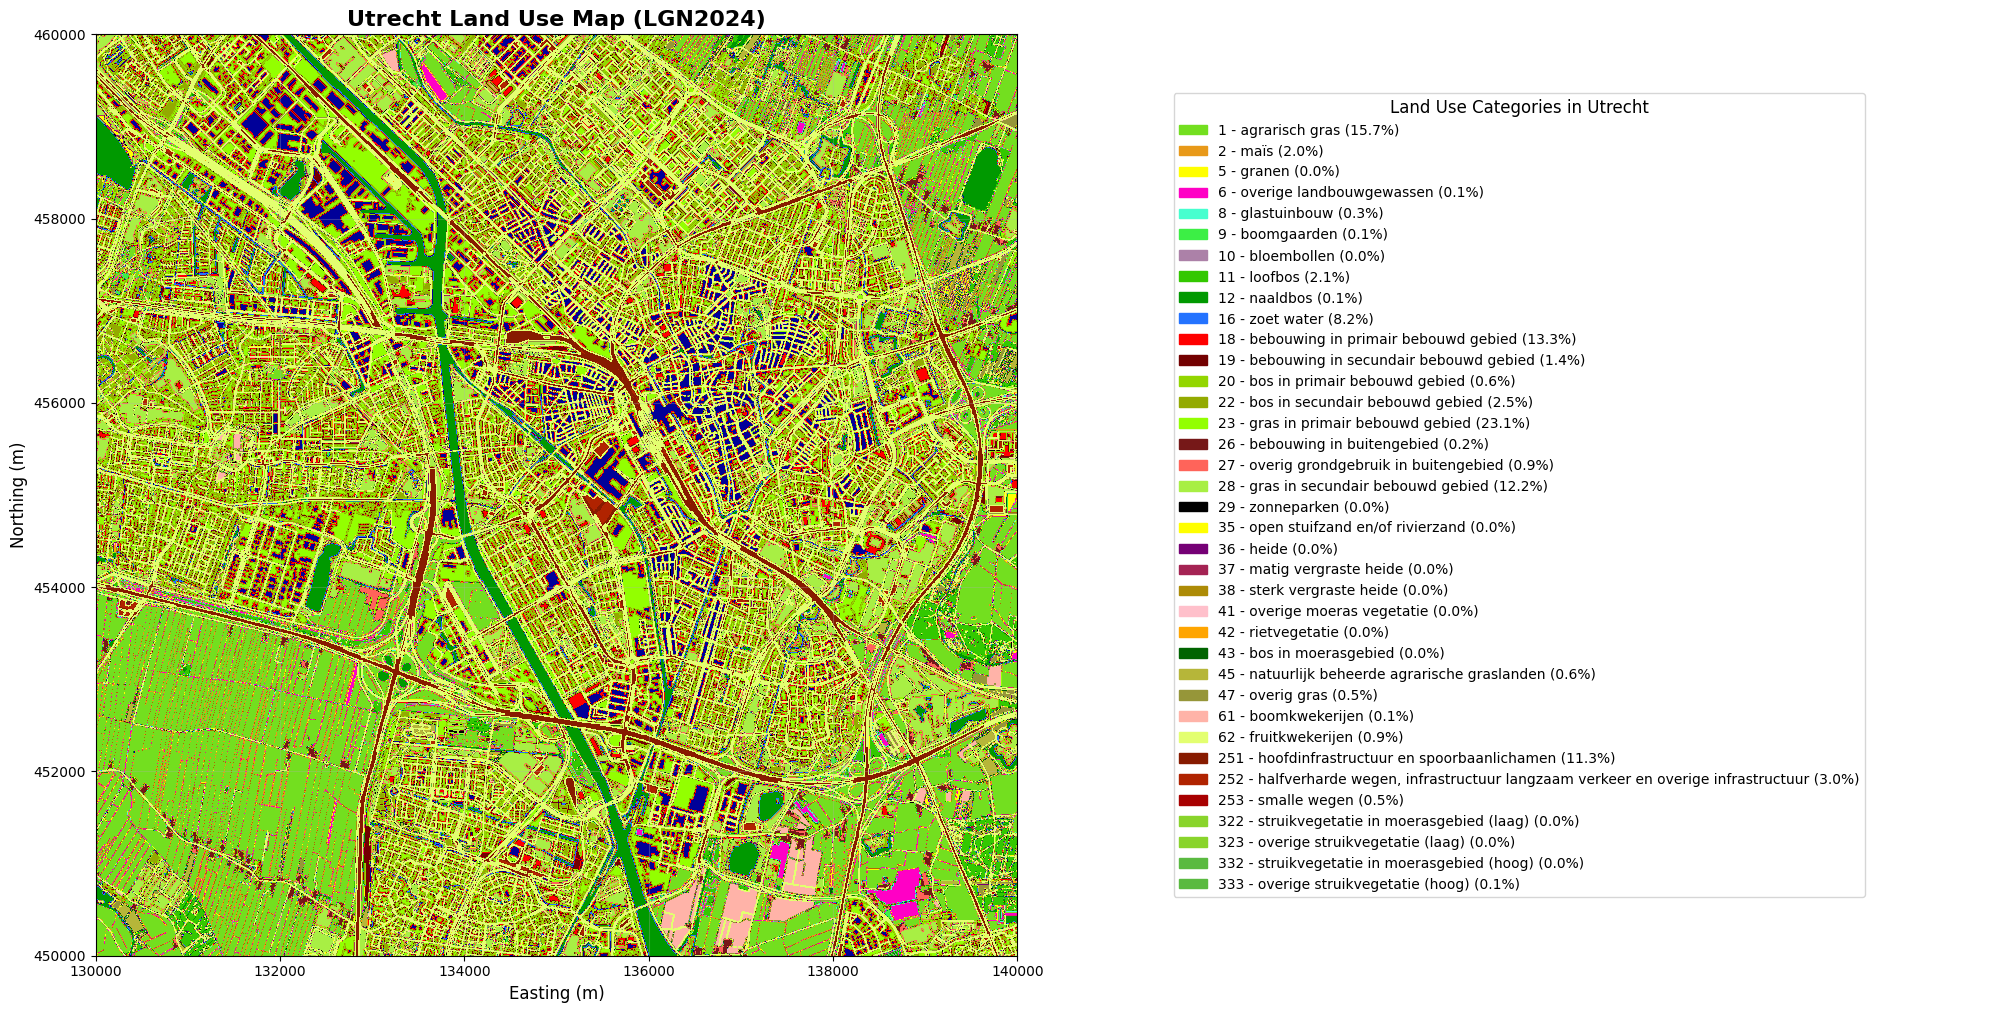

Map covers area: {'left': 130000, 'bottom': 450000, 'right': 140000, 'top': 460000}
Raster dimensions: (2000, 2000)
Number of land use categories in Utrecht: 37
Total area covered: 100.0 km²


In [11]:

# Create a custom colormap based on the legend
def create_custom_colormap(legend_dict):
    """Create a custom colormap from the legend dictionary"""
    # Get all unique pixel values and their colors
    pixel_values = sorted(legend_dict.keys())
    colors = [legend_dict[val]['color'] for val in pixel_values]
    
    # Create a ListedColormap
    cmap = mcolors.ListedColormap(colors)
    
    # Create normalization bounds
    bounds = pixel_values + [pixel_values[-1] + 1]  # Add upper bound
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    return cmap, norm, pixel_values

# Create the custom colormap
custom_cmap, norm, pixel_values = create_custom_colormap(legend)

# Create the map visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the Utrecht raster data with custom colors
im = ax1.imshow(utrecht_data, cmap=custom_cmap, norm=norm, extent=[
    utrecht_bbox["left"], utrecht_bbox["right"], 
    utrecht_bbox["bottom"], utrecht_bbox["top"]
])

ax1.set_title('Utrecht Land Use Map (LGN2024)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Easting (m)', fontsize=12)
ax1.set_ylabel('Northing (m)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Format the axes to show coordinates properly
ax1.ticklabel_format(style='plain', axis='both')

# Create legend with only categories present in Utrecht data
unique_values_in_data = np.unique(utrecht_data)
legend_patches = []

for pixel_val in unique_values_in_data:
    if pixel_val in legend:
        color = legend[pixel_val]['color']
        label = legend[pixel_val]['label']
        # Calculate percentage for this category
        percentage = (np.sum(utrecht_data == pixel_val) / utrecht_data.size) * 100
        legend_patches.append(Patch(color=color, label=f'{label} ({percentage:.1f}%)'))

# Create the legend on the second subplot
ax2.axis('off')
ax2.legend(handles=legend_patches, loc='center', fontsize=10, 
          title='Land Use Categories in Utrecht', title_fontsize=12)

plt.tight_layout()
plt.show()

print(f"Map covers area: {utrecht_bbox}")
print(f"Raster dimensions: {utrecht_data.shape}")
print(f"Number of land use categories in Utrecht: {len(unique_values_in_data)}")
print(f"Total area covered: {(utrecht_bbox['right'] - utrecht_bbox['left']) * (utrecht_bbox['top'] - utrecht_bbox['bottom']) / 1000000:.1f} km²")


# Below was to answer a question Rins asked

In [12]:
# Calculate pixel size from the raster metadata
with rasterio.open(file_path_tiff) as src:
    # Get the transform (affine transformation matrix)
    transform = src.transform
    
    # Extract pixel size from transform
    pixel_width = abs(transform[0])  # Width of pixel in map units
    pixel_height = abs(transform[4])  # Height of pixel in map units
    
    # Print raster metadata
    print("=== RASTER METADATA ===")
    print(f"CRS: {src.crs}")
    print(f"Bounds: {src.bounds}")
    print(f"Width: {src.width} pixels")
    print(f"Height: {src.height} pixels")
    print(f"Number of bands: {src.count}")
    print(f"Data type: {src.dtypes[0]}")
    
    print(f"\n=== PIXEL RESOLUTION ===")
    print(f"Pixel width: {pixel_width} meters")
    print(f"Pixel height: {pixel_height} meters")
    print(f"Pixel area: {pixel_width * pixel_height} square meters")
    print(f"Pixel area: {(pixel_width * pixel_height) / 10000:.4f} hectares")
    print(f"Pixel area: {(pixel_width * pixel_height) / 1000000:.6f} square kilometers")
    
    # Calculate Utrecht area details
    print(f"\n=== UTRECHT AREA CALCULATIONS ===")
    print(f"Utrecht data shape: {utrecht_data.shape}")
    total_pixels_utrecht = utrecht_data.size
    total_area_m2 = total_pixels_utrecht * (pixel_width * pixel_height)
    total_area_km2 = total_area_m2 / 1000000
    
    print(f"Total pixels in Utrecht area: {total_pixels_utrecht:,}")
    print(f"Total Utrecht area: {total_area_m2:,.0f} square meters")
    print(f"Total Utrecht area: {total_area_km2:.2f} square kilometers")
    
    # Verify with bounding box calculation
    bbox_area_m2 = (utrecht_bbox["right"] - utrecht_bbox["left"]) * (utrecht_bbox["top"] - utrecht_bbox["bottom"])
    bbox_area_km2 = bbox_area_m2 / 1000000
    print(f"Utrecht bounding box area: {bbox_area_km2:.2f} square kilometers")
    
    print(f"\n=== PIXEL SCALE REFERENCE ===")
    print(f"1 pixel = {pixel_width}m × {pixel_height}m = {pixel_width * pixel_height} m²")
    print(f"1 pixel = {(pixel_width * pixel_height) / 10000:.4f} hectares")
    
    # For context - common pixel sizes
    print(f"\n=== RESOLUTION COMPARISON ===")
    if pixel_width == 5:
        print("✓ This is high-resolution land use data (5m pixels)")
    elif pixel_width == 10:
        print("✓ This is medium-resolution data (10m pixels)")
    elif pixel_width == 30:
        print("✓ This is Landsat-resolution data (30m pixels)")
    else:
        print(f"✓ Custom resolution: {pixel_width}m pixels")


=== RASTER METADATA ===
CRS: LOCAL_CS["Amersfoort / RD New",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=0.0, bottom=300000.0, right=280000.0, top=625000.0)
Width: 56000 pixels
Height: 65000 pixels
Number of bands: 1
Data type: uint16

=== PIXEL RESOLUTION ===
Pixel width: 5.0 meters
Pixel height: 5.0 meters
Pixel area: 25.0 square meters
Pixel area: 0.0025 hectares
Pixel area: 0.000025 square kilometers

=== UTRECHT AREA CALCULATIONS ===
Utrecht data shape: (2000, 2000)
Total pixels in Utrecht area: 4,000,000
Total Utrecht area: 100,000,000 square meters
Total Utrecht area: 100.00 square kilometers
Utrecht bounding box area: 100.00 square kilometers

=== PIXEL SCALE REFERENCE ===
1 pixel = 5.0m × 5.0m = 25.0 m²
1 pixel = 0.0025 hectares

=== RESOLUTION COMPARISON ===
✓ This is high-resolution land use data (5m pixels)


# Filter out categories we dont need

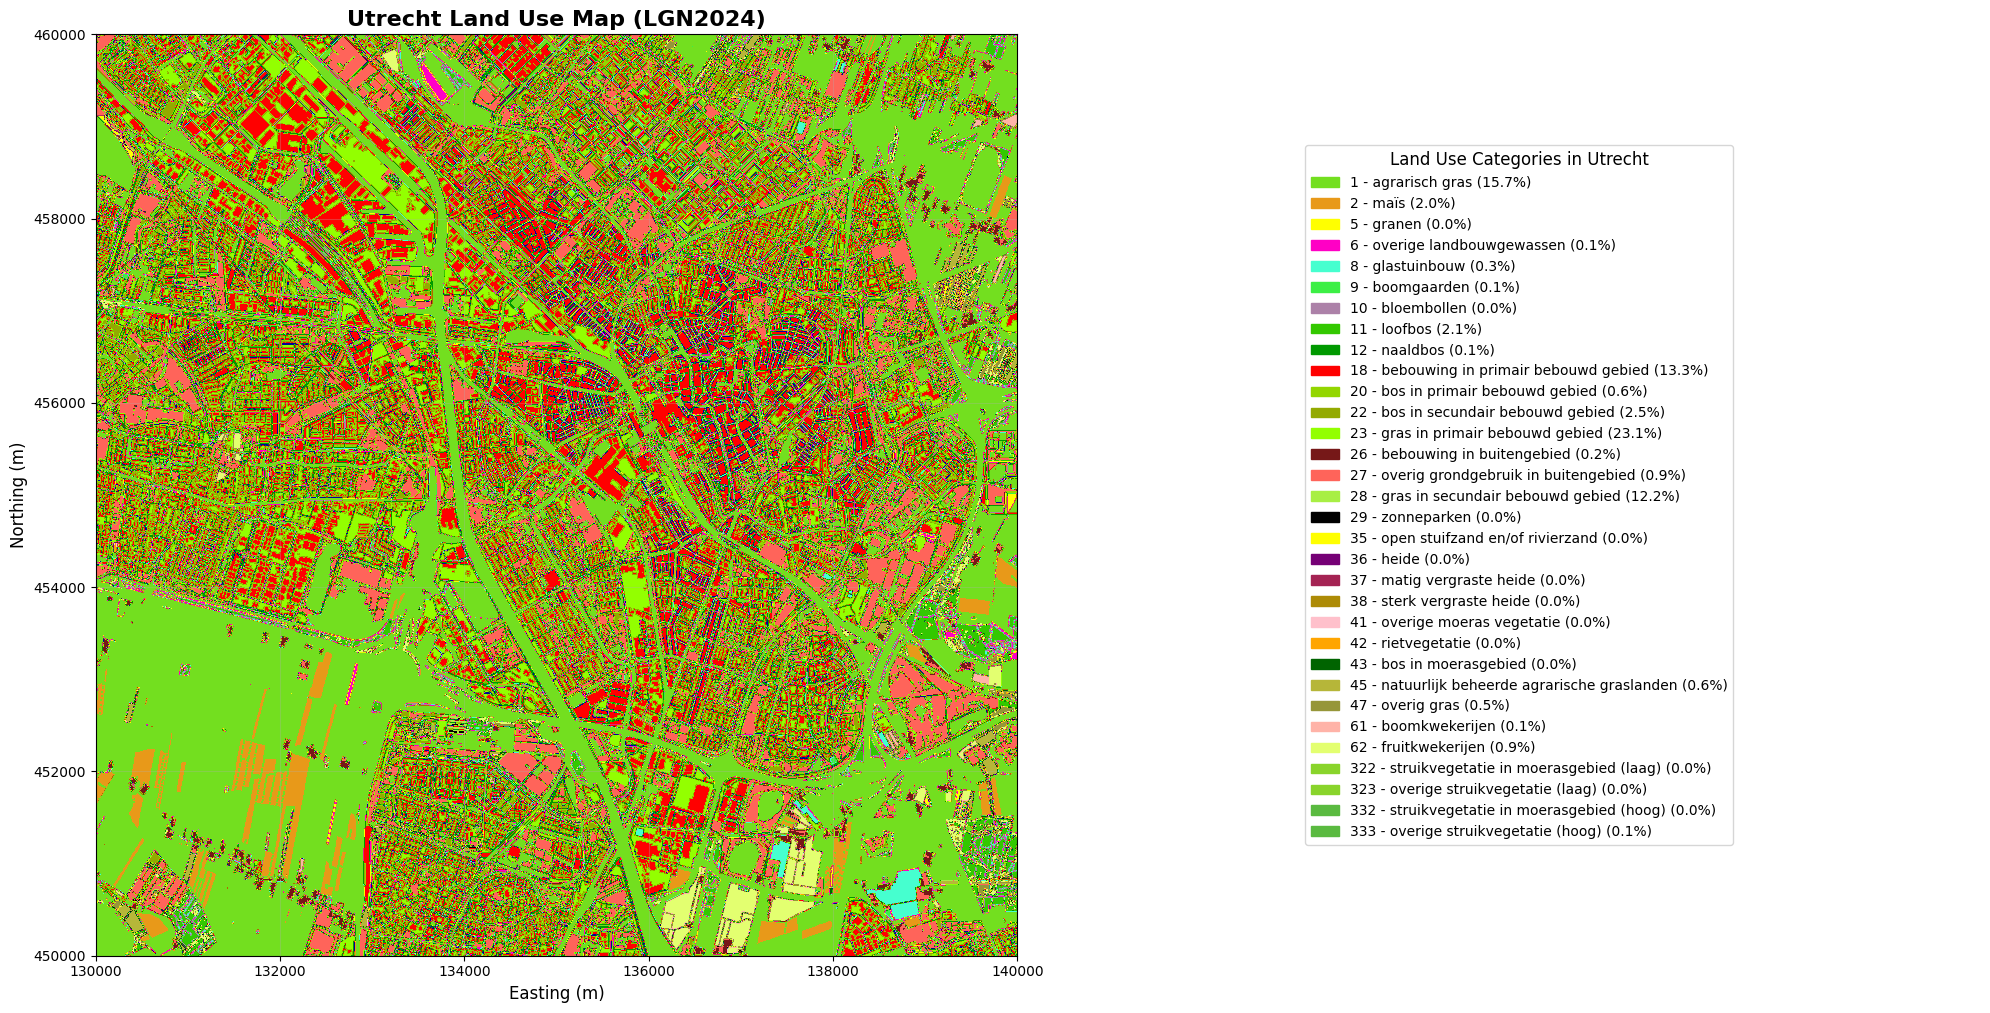

Map covers area: {'left': 130000, 'bottom': 450000, 'right': 140000, 'top': 460000}
Raster dimensions: (2000, 2000)
Number of land use categories in Utrecht: 33
Total area covered: 100.0 km²
Excluded categories: [16, 19, 251, 252, 253]


In [16]:
exclude_categories = [16, 19,251,252,253] 
# Create a custom colormap based on the legend
def create_custom_colormap(legend_dict):
    """Create a custom colormap from the legend dictionary"""
    # Filter out excluded categories from legend
    filtered_legend = {k: v for k, v in legend_dict.items() if k not in exclude_categories}
    
    # Get all unique pixel values and their colors
    pixel_values = sorted(filtered_legend.keys())
    colors = [filtered_legend[val]['color'] for val in pixel_values]
    
    # Create a ListedColormap
    cmap = mcolors.ListedColormap(colors)
    
    # Create normalization bounds
    bounds = pixel_values + [pixel_values[-1] + 1]  # Add upper bound
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    return cmap, norm, pixel_values

# Create the custom colormap
custom_cmap, norm, pixel_values = create_custom_colormap(legend)

# Create filtered data by masking excluded categories
filtered_utrecht_data = np.copy(utrecht_data)
for category in exclude_categories:
    filtered_utrecht_data[filtered_utrecht_data == category] = 0  # Set to 0 (transparent/no data)

# Create the map visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the Utrecht raster data with custom colors
im = ax1.imshow(filtered_utrecht_data, cmap=custom_cmap, norm=norm, extent=[
    utrecht_bbox["left"], utrecht_bbox["right"], 
    utrecht_bbox["bottom"], utrecht_bbox["top"]
])

ax1.set_title('Utrecht Land Use Map (LGN2024)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Easting (m)', fontsize=12)
ax1.set_ylabel('Northing (m)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Format the axes to show coordinates properly
ax1.ticklabel_format(style='plain', axis='both')

# Create legend with only categories present in Utrecht data (excluding filtered ones)
unique_values_in_data = np.unique(filtered_utrecht_data)
legend_patches = []

for pixel_val in unique_values_in_data:
    if pixel_val in legend and pixel_val not in exclude_categories:
        color = legend[pixel_val]['color']
        label = legend[pixel_val]['label']
        # Calculate percentage for this category
        percentage = (np.sum(filtered_utrecht_data == pixel_val) / filtered_utrecht_data.size) * 100
        legend_patches.append(Patch(color=color, label=f'{label} ({percentage:.1f}%)'))

# Create the legend on the second subplot
ax2.axis('off')
ax2.legend(handles=legend_patches, loc='center', fontsize=10, 
          title='Land Use Categories in Utrecht', title_fontsize=12)

plt.tight_layout()
plt.show()

print(f"Map covers area: {utrecht_bbox}")
print(f"Raster dimensions: {utrecht_data.shape}")
print(f"Number of land use categories in Utrecht: {len(unique_values_in_data)}")
print(f"Total area covered: {(utrecht_bbox['right'] - utrecht_bbox['left']) * (utrecht_bbox['top'] - utrecht_bbox['bottom']) / 1000000:.1f} km²")
print(f"Excluded categories: {exclude_categories}")